In [1]:
%load_ext autoreload
%autoreload 2
%env https_proxy=http://proxy:80
%env http_proxy=http://proxy:80

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import kornia.augmentation as K
from torchvision import models
import sys

from inversion.utils import *
from inversion.clip_guided_stable_diffusion import *
from tqdm.notebook import tqdm
import numpy as np
from inversion.clip_utils import *
from inversion.run_config import RunConfig
from inversion.reconstruction import run_reconstructions
from IPython.display import display, Markdown, Image as IPyImage

import PIL
import json

env: https_proxy=http://proxy:80
env: http_proxy=http://proxy:80


/home/woody/iwi1/iwi1106h/software/private/conda/envs/bube/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [3]:
# Load the individual components of Stable Diffusion
diffusion_model_name = "CompVis/stable-diffusion-v1-4"
clip_model_name = "openai/clip-vit-large-patch14"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_suite = CLIPSuite(diffusion_model_name, clip_model_name)

In [3]:
# Load the VAE, UNet, and text encoder
unet = lambda x: clip_suite.vae()(x)
scheduler = clip_suite.scheduler()

text_encoder = lambda x: clip_suite.text_encoder()(x)
text_projector = lambda x: clip_suite.text_projector()(x)
image_encoder = lambda x: clip_suite.image_encoder()(x)
image_projector = lambda x: clip_suite.image_projector()(x)
clip_model = lambda x: clip_suite.clip_model()(x)
tokenizer = clip_suite.tokenizer()
image_processor = clip_suite.image_processor()

In [4]:
mapping_model, mapping_model_id = get_simple_sclip_model()
mapping_model.to(device)

Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth


/home/woody/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=1024, bias=True)
)

# Restnet vs Surrogate CLIP vs RN + SCLIP

In [4]:
configs = []
init_conf = RunConfig(
    loss_scale_rn = 1.0,
    )
configs.append(init_conf)
#configs.append(RunConfig( loss_scale_clip = 1.0))

for conf in configs:
    conf.loss_scale["tv"] = 1
    conf.loss_function["tv"] = "squared_relu"
    conf.loss_calculate["rn"] = True
    conf.loss_calculate["tv"] = True
    conf.loss_calculate["lpips_vgg"] = False
    conf.loss_function["rn"] = "mse"
    conf.optimization_space = "image"
    conf.iterations = 3000

img_path = "Images/14042.jpg"


result = run_reconstructions(img_path=img_path, config=init_conf,
                    img_logging_freq=100, reconstructions_per_img=4,
                    clip_suite=clip_suite, run_tags=["ref_vgg16_loss", "init", "test"])

Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth


/home/woody/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))
wandb: Curre

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/woody/iwi1/iwi1106h/software/private/conda/envs/bube/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/woody/iwi1/iwi1106h/software/private/conda/envs/bube/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/woody/iwi1/iwi1106h/software/private/conda/envs/bube/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]
Loading model from: /home/woody/iwi1/iwi1106h/software/private/conda/envs/bube/lib/python3.11/site-packages/lpips/weights/v0.1/squeeze.pth


/home/woody/iwi1/iwi1106h/software/private/conda/envs/bube/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dic

current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current_resolution,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▅▅▅▅▅▅▅▅▅█████████████████
current_learning_rate,10
current_resolution,224


In [6]:
network_inits = {
    'resnet18': init_torch_resnet18,
    'resnet34': init_torch_resnet34,
    'resnet50': init_torch_resnet50,
    'resnet101': init_torch_resnet101,
    'resnet152': init_torch_resnet152,
    'vgg16': init_torch_vgg16,
    'vgg19': init_torch_vgg19,
    'identity': init_torch_identity,
    'clip': lambda: (lambda x: clip_suite.image_projector()(x).image_embeds),
}

for model_name in ['resnet101', 'vgg16', 'clip']:
    conf = RunConfig(
            loss_scale_tv=1,
            loss_function_tv="squared_relu",
            loss_scale_rn=1,
            loss_function_rn="mse",
        )
    #configs.append(RunConfig( loss_scale_clip = 1.0))

    #conf.loss_calculate["clip"] = True
    #conf.loss_calculate["lpips_alex"] = True
    #conf.loss_calculate["lpips_vgg"] = True
    #conf.loss_calculate["lpips_squeeze"] = True
    #conf.loss_calculate["avg"]["vgg16"] = True
    conf.loss_calculate["ref"][model_name] = True
    conf.loss_scale["ref"][model_name] = 1
    conf.optimization_space = "image"
    conf.iterations = 500

    model = network_inits[model_name]()
    embeds = model(result["reconstructions"])
    embeds_avg = embeds.mean(dim=0, keepdim=False)

    conf.ref_embedding[model_name] = embeds_avg
    print(embeds_avg.shape)

    run_reconstructions(img_path=img_path, config=conf,
                        img_logging_freq=100, reconstructions_per_img=4,
                        clip_suite=clip_suite, run_tags=["ref", f"ref_{model_name}_loss", "rerun", "test"])

torch.Size([2048, 7, 7])
Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth


/home/woody/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current_resolution,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
current_learning_rate,10
current_resolution,64


torch.Size([4096])
Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth


/home/woody/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current_resolution,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████
current_learning_rate,10
current_resolution,64


torch.Size([768])
Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth


/home/woody/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current_resolution,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████
current_learning_rate,10
current_resolution,64


In [28]:
for model_name in ['clip', 'vgg16', 'resnet18', 'resnet50', 'resnet152']:
    conf = RunConfig(
        )
    #configs.append(RunConfig( loss_scale_clip = 1.0))

    conf.loss_scale["tv"] = 1
    conf.loss_function["tv"] = "squared_relu"
    conf.loss_calculate["clip"] = True
    conf.loss_calculate["lpips_alex"] = True
    conf.loss_calculate["lpips_vgg"] = True
    conf.loss_calculate["lpips_squeeze"] = True
    conf.loss_calculate["rn"] = True
    conf.loss_calculate["tv"] = True
    conf.loss_function["rn"] = "mse"
    conf.loss_calculate["avg"]["vgg16"] = True
    conf.loss_calculate["ref"][model_name] = True
    conf.loss_scale["ref"][model_name] = 1.0
    conf.loss_scale["rn"] = 1.0
    conf.optimization_space = "image"
    conf.iterations = 3000

    model = network_inits[model_name]()
    embeds = model(result["reconstructions"])
    embeds_avg = embeds.mean(dim=0, keepdim=False)
    conf.ref_embedding[model_name] = embeds_avg

    run_reconstructions(img_path=img_path, config=conf,
                        img_logging_freq=100, reconstructions_per_img=4,
                        clip_suite=clip_suite, run_tags=[f"ref_{model_name}_loss", "rerun", "test"])

Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth


/home/hpc/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


correlation_pearson_vgg16_0_vs_1,█▆▆▂▆▆▂▅▅▃▅▄▅▄▂▅▄▃▇▃▆█▇▃▄▂▄▁▄▂▅▇▁▄▄▅▆▃▇▁
correlation_pearson_vgg16_2_vs_3,▇▇▅█▁█▇█▅▄▇▆▇▅▂▅▅▄▃▆▇▅▁▆▆▄█▄▄▇▂▆█▇▇▇▇▇█▅
correlation_pearson_vgg16_orig_vs_0,▁▁▂▁▁▃▂▂▂▂▃▃▄▅▃▅▄▃▄▄▅▅▅▆▆▄▆▇▄▄██▆█▅▇▇▇▇▇
correlation_pearson_vgg16_orig_vs_avg,▁▁▁▁▂▂▂▂▂▂▄▄▃▄▃▃▅▅▆▆▅▆▅▇▇▆▅▇██▇▇▇▇█▇▇█▇▇
correlation_pearson_vgg16_orig_vs_prod,▁▁▁▁▁▁▁▂▂▂▃▃▃▅▃▃▅▅▃▄▅▅▄▄▄▅▆▆▇▄▅▅▇██▇▆▇▇▆
correlation_spearman_vgg16_0_vs_1,▆▇▇▇█▇█▆▆▃▅▆▁▆▇▃▇▆▅▃▂▄▅▇▅▇▄▆█▄▄▆▃▆█▆█▆▄▆
correlation_spearman_vgg16_2_vs_3,█▄▅▄▆▂▂▂▄▂▃▃▂▄▁▁▅▅▅▂▂▃▃▅▄▄▅▅▄▆▅▄▄▃▂▃▄▄▃▆
correlation_spearman_vgg16_orig_vs_0,▂▁▁▂▃▂▂▃▄▂▅▃▃▂▅▄▅▇▃▆▅▇▆▇▅▄▇▄▅▄▇█▅▇▇█▄▆██
correlation_spearman_vgg16_orig_vs_avg,▁▁▁▂▁▃▃▃▄▄▆▆▆▅▇▇▆▇▆▅▇▆▇▆▅▇▆█▇▇▇▇███▇███▇
correlation_spearman_vgg16_orig_vs_prod,▂▁▁▁▂▂▂▃▃▄▃▃▃▅▄▃▆▅▆▄▆▇▆▆▆▆▇▆▅▇▇▆▆█▆▇█▇▆▇
current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth


/home/hpc/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


correlation_pearson_vgg16_0_vs_1,▄▇▄▁▄▅▅▅▆▄▆▆▄▆▃▇▄▄▅▇▇▆▆█▇▆▄▇▆▇▆█▆██▇▇█▇▇
correlation_pearson_vgg16_2_vs_3,▅▁▆▇▄▄▄▂▂▃▆▇▄▆▆▆▆▇▇▆▇▇▇▇█▇██▅▇▇▇▇██▇█▇▇▆
correlation_pearson_vgg16_orig_vs_0,▅▁▁▆▂▂▅▇▆█▆▇▆▅▇█▇▇▅▇▅▇█▆▇▇▅▆▇▇█▇▇▇▆█▇▇▇▆
correlation_pearson_vgg16_orig_vs_avg,▁▅▆▇▄▄▇█▆█▇▇▇▇▆▇▇█▇█▇██▇▇█▇▇▇█▇▇▇▇██▇▇▇▇
correlation_pearson_vgg16_orig_vs_prod,▁▄▂▄▆▆▇▇▇▇▇▇▇▆█▇▆▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇█████▇▇
correlation_spearman_vgg16_0_vs_1,▂▃▃▅▇▃▁▂▆▇▆▆▅▄▁▇▇▄▆▇▆██▆█▇█▆█▇▆▇▆▇▇▇▇█▇▆
correlation_spearman_vgg16_2_vs_3,▃▃▃▁▃▅▄▅▆▆▆▆▃▄▄▆▇▆▆▇▅▆▇▄▆█▆▆▆█▆▇██▇▇▆▆█▇
correlation_spearman_vgg16_orig_vs_0,▂▆▁▃▆▂▆▆▇▄▇▆▇▄▇▇▇▇▆▆▆▆███▇▇▆▆█▇█▆▇▆█▆▇▇▇
correlation_spearman_vgg16_orig_vs_avg,▁▅▆▃▅▄▅▆▅▆▇▇▆▆▆▆▆▇▆▆▇▆▇▇█▇▇█▇▇▇▇▇▇▇▇█▇██
correlation_spearman_vgg16_orig_vs_prod,▃▂▁▅▄▅▃▃▅▆▇▅▆▇▆▆▆▇▇▇▅▇▆▆▇▇▆▇▇▇█▇▇▇▇█▇█▇█
current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth


/home/hpc/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


correlation_pearson_vgg16_0_vs_1,▇▅▃▆▆▅▅▆▅▂▂▅▄▅▅▇▃▇▁▂▇▆▂▇▆▆█▇▅▇▅▅▅▇▄▃▇▅▇▆
correlation_pearson_vgg16_2_vs_3,▅▅▇▇▇▆▁▆▆▇▅▆▄▇▅▄▇▆▅▄▅▅▅▄▅▆▆▆▅▆▇▅▇██▅▄▇▇▇
correlation_pearson_vgg16_orig_vs_0,▂▂▂▁▃▅▄▂▃▂▄▆▂▆▄▆▅▇▇▇▇▆▄█▇▆▆▄▇█▄██▆▇▄██▇▇
correlation_pearson_vgg16_orig_vs_avg,▁▁▃▄▃▄▅▅▅▇▇▇▇▆▇▆▇▇▆▇▇▆▇▆▆▆▇▆▇███▇█▇▆█▇▇▇
correlation_pearson_vgg16_orig_vs_prod,▁▁▁▁▂▃▃▂▄▄▅▅▄▆▄▅▆▃▆▇▅▄▆▅▅▄▆▇▇▇▇▇▅▅▇▅▆▆█▇
correlation_spearman_vgg16_0_vs_1,▅▃▅▅▂▆▄▃▆▄▅▃▄▁▄▆▅▄▄▅▄▂█▅▄▅▄▃▅▄▃▇▄▃▅▅▆▄▇▃
correlation_spearman_vgg16_2_vs_3,▄▆▆▄▅▂▆▅▁▅▅▄▅▃▆▄▇▁▆▆▆▂▇▅▅▄▇▂▆▃▄▃█▇▄█▅▂▄▅
correlation_spearman_vgg16_orig_vs_0,▂▁▂▁▂▂▂▅▅▆▂▆▆▆▆▅▅▇▅▆▄▆▇▆▇▅▆▅▆▆█▆▇▄▇▅█▆▇▅
correlation_spearman_vgg16_orig_vs_avg,▂▂▁▂▁▁▅▄▃▅▄▆▄▅▆▆▆▅▇▇▆▇▅▇▇█▆▇▇█▆▇█▇██████
correlation_spearman_vgg16_orig_vs_prod,▁▂▁▁▁▃▃▃▄▄▄▅▆▄▅▅▄▆▄▅▅▅▆▆▆▇██▆▇▇▅▆▆▆█▇▆▇▆
current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth


/home/hpc/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


correlation_pearson_vgg16_0_vs_1,█▄▅▅▆▆▄▄▂▂▄▄▄▄▂▃▄▂▄▃▁▂▃▅▂▃▃▄▅▄▃▅▃▅▅▄▃▄▃▄
correlation_pearson_vgg16_2_vs_3,█▄█▅▇█▅▆▇▆▅▂▂▁▂▁▆▁▂▆▆▅▅▃▆▂▅▅▄▆▇▅▄▆▄▃▇▂▆▃
correlation_pearson_vgg16_orig_vs_0,▁▃▁▂▂▄▄▃▅▆▆▅▃▅▆▅▆▄▇▆▄▄▅▆▇▇▇▄▅▇▇▇█▇▆▇█▇██
correlation_pearson_vgg16_orig_vs_avg,▂▁▂▂▂▄▄▂▃▃▄▄▄▅▅▇▅▆▆▇▅▆▇▇▇▇▇▇▇▇█▇▇▇▇▇███▇
correlation_pearson_vgg16_orig_vs_prod,▁▁▁▁▂▁▁▁▁▂▃▃▃▂▂▄▄▅▅▅▄▆▅▅▄▄▇▇▆████▆▇▇██▇▇
correlation_spearman_vgg16_0_vs_1,▅█▆▄▆▇▅▄▁▂▆▃▄▄▂▄▄▄▄▄▁▄▅▄▅▅▃▂▃▅▆▅▅▅▅▄▅▅▅▅
correlation_spearman_vgg16_2_vs_3,▄█▄▆▅▆▅▄▄▁▃▄▅▄▃▅▂▅▅▃▆▄▃▃▅▄▃▅▃▆▅▆▃▄▆▆▄▇▅▄
correlation_spearman_vgg16_orig_vs_0,▂▁▁▁▂▂▄▂▄▂▃▄▄▄▄▃▅▆▆▄▆▄▆▇▇▆▅▇▇▇▇█▅▆▆▅██▇▇
correlation_spearman_vgg16_orig_vs_avg,▁▂▁▂▃▄▂▃▄▃▆▅▆▅▅▆▅▆▆▅▇▆▇▇█▇█▇▇▇▇█▇▇▇█▇█▇▇
correlation_spearman_vgg16_orig_vs_prod,▂▁▁▃▃▄▅▅▅▆▆▆▆▇▅▅▆▄▇▆▅▆▇▇▆▇▇▆▆█▇▇▇▆▇▇█▇▇▆
current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth


/home/hpc/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


correlation_pearson_vgg16_0_vs_1,▅▇█▇▇▅▅▅▃▅▄▁▅▅▅▆▂▅▅▇▇▇▃▄▄▅▄▆▄▃▇▅▅▄▇▅▅▅▆▅
correlation_pearson_vgg16_2_vs_3,▇▂▆█▆▃▆█▆▇▃▂▂▄█▂▂▇▅▁▂▄▅▃▄█▂▇▆▇▅▄▅▆▅▅▇▃▂▄
correlation_pearson_vgg16_orig_vs_0,▁▃▂▂▅▃▂▂▄▅▄▅▅▂▁█▃▇▅█▇▇▆▇███▇██▆▇█▇▇▇▆▇▇▆
correlation_pearson_vgg16_orig_vs_avg,▁▂▂▂▃▃▄▃▄▆▆▅▆▇▆▆▆▆▇▇▇▇▇▆▇▇▇████▇▇█▇▇▇▇█▇
correlation_pearson_vgg16_orig_vs_prod,▁▁▁▁▁▁▁▁▃▄▂▄▄▂▃▃▅▄▄▅▃▆▆▆▅▆▇▆▆▇▇▇█▆▇██▇▇▆
correlation_spearman_vgg16_0_vs_1,▆▅█▅▄▇▅▆▅▃▄▂▅▄▅▆▂▄▁█▃▅▃▆▂▇▆▄▅▆█▇▆▅▅▆▄▅▇▇
correlation_spearman_vgg16_2_vs_3,█▆▇▄▇▄▆▁▆▃▁▂▆▆▇▅▂▄▃▄▆▂▄▄▂▄▆▃▆▃▆▁▅▆▆▅▅▃▅▅
correlation_spearman_vgg16_orig_vs_0,▁▃▃▃▄▅▄▅▄▄▃▇▇▄▆▆██▇▇████████▇█▅▇▇▇█▇▇▇▇▇
correlation_spearman_vgg16_orig_vs_avg,▁▂▂▂▃▁▄▄▃▄▅▄▄▅▄▄▄▆▇▇▇▆▇▇▆▆▇▇▆▇████▇█▇▇▇▇
correlation_spearman_vgg16_orig_vs_prod,▁▁▁▁▁▃▅▅▄▄▄▄▄▅▆▆▇▆█▆▇▇█▇██▇▇█▇▇█▇▆▆▇█▇▇▆
current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


# Using GAN as initilalization

In [ ]:
configs = []
for noising_factor in [1.0]:
    configs.append(RunConfig(
        loss_scale_rn=1.0,
        loss_scale_tv=0.2,
        loss_scale_classification_1k=0.0,
        loss_calculate_clip=True,
        loss_calculate_rn=True,
        loss_calculate_tv=True,
        loss_calculate_classification_1k=True,
        init_method="gan_v1",
        init_noising_factor=noising_factor,
        iterations=3000,
    ))

configs = []
configs.append(RunConfig(
                loss_scale_rn=1,
                loss_scale_tv=0.2,
                loss_scale_classification_1k=0.0,
                loss_scale_clip=0.0,
                loss_calculate_clip=True,
                loss_calculate_rn=True,
                loss_calculate_tv=True,
                loss_calculate_classification_1k=True,
                loss_function_rn="mse",
                optimization_space="gan_latent",
                optimization_space_changes={ 600: "image" },
                scale_steps={-1: 64, 900: 128, 1200: 224},
                iterations=3000,
))

img_paths = ["Images/14042.jpg"]
# img_paths = ["Images/14034.jpg"]

for i, img_path in enumerate(img_paths):
    for ii, config in enumerate(configs):
        print(f"Running reconstruction {i+1}/{len(img_paths)} with config {ii+1}/{len(configs)}: {config.get_as_dict()}")
        # Initialize a wand
        run_reconstructions(img_path=img_path, config=config,
                            img_logging_freq=50, reconstructions_per_img=10,
                            clip_suite=clip_suite, run_tags=["gen2", "gan_init", "test"])

Running reconstruction 1/1 with config 1/1: {'loss_scale': {'classification_1k': 0.0, 'clip': 0.0, 'rn': 1, 'sclip': 0.0, 'tv': 0.2, 'lpips_alex': 0.0, 'lpips_vgg': 0.0, 'lpips_squeeze': 0.0}, 'loss_calculate': {'classification_1k': True, 'rn': True, 'clip': True, 'sclip': False, 'tv': True, 'lpips_alex': False, 'lpips_vgg': False, 'lpips_squeeze': False}, 'loss_function': {'classification_1k': 'cosine_similarity', 'clip': 'cosine_similarity', 'rn': 'mse', 'sclip': 'cosine_similarity'}, 'init_method': 'gaussian', 'init_noising_factor': 0.0, 'scale_steps': {-1: 64, 900: 128, 1200: 224}, 'learning_rate': 10, 'learning_rate_changes': {}, 'iterations': 3000, 'fixed_gradient_length': True, 'optimization_space': 'gan_latent', 'optimization_space_changes': {600: 'image'}}


/home/hpc/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth


current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current_resolution,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████████████
current_learning_rate,10
current_resolution,64


Loading model from ./checkpoints/DCGen_64_128_2048/2024-10-28T22:30:02_epoch_23.pth


/home/hpc/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


# CLIP loss

# Reconstruction with diffusion steps

## RN only

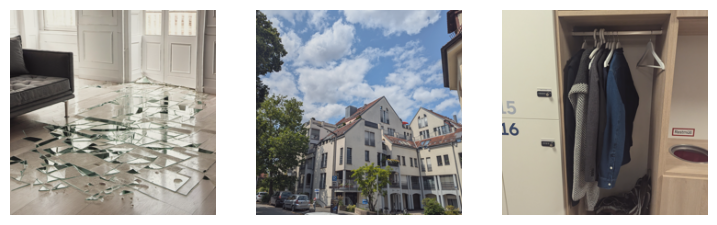

Loading model from ./checkpoints/rn_to_imclip_linear_mapping_2048_1024_1024/2024-12-14T18:12:58_epoch_00_batch_000700.pth
torch.Size([12, 3, 512, 512])
torch.Size([12, 4, 64, 64])


/home/hpc/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


Iteration:    0, Loss: 0.5945, TV Loss: 1.8461, Total Loss: 0.9637


![Plot](reconstruction_0000.png)

Iteration:   50, Loss: 0.2506, TV Loss: 1.1132, Total Loss: 0.4732
Iteration:  100, Loss: 0.2243, TV Loss: 0.8286, Total Loss: 0.3900
Iteration:  150, Loss: 0.2158, TV Loss: 0.7195, Total Loss: 0.3597
torch.Size([12, 3, 512, 512])
torch.Size([12, 4, 64, 64])
Iteration:  200, Loss: 0.2244, TV Loss: 0.6588, Total Loss: 0.3562
Iteration:  250, Loss: 0.1722, TV Loss: 0.6394, Total Loss: 0.3001
Iteration:  300, Loss: 0.1384, TV Loss: 0.6250, Total Loss: 0.2634
Iteration:  350, Loss: 0.1465, TV Loss: 0.6169, Total Loss: 0.2699
torch.Size([12, 3, 512, 512])
torch.Size([12, 4, 64, 64])
Iteration:  400, Loss: 0.1638, TV Loss: 0.3054, Total Loss: 0.2249
Iteration:  450, Loss: 0.0995, TV Loss: 0.3756, Total Loss: 0.1746
Iteration:  500, Loss: 0.0725, TV Loss: 0.3878, Total Loss: 0.1501


![Plot](reconstruction_0500.png)

Iteration:  550, Loss: 0.0706, TV Loss: 0.3911, Total Loss: 0.1489
torch.Size([12, 3, 512, 512])
torch.Size([12, 4, 64, 64])
Iteration:  600, Loss: 0.0676, TV Loss: 0.3917, Total Loss: 0.1459
Iteration:  650, Loss: 0.0699, TV Loss: 0.3911, Total Loss: 0.1481
Iteration:  700, Loss: 0.0666, TV Loss: 0.3866, Total Loss: 0.1440
Iteration:  750, Loss: 0.0721, TV Loss: 0.3864, Total Loss: 0.1494
torch.Size([12, 3, 512, 512])
torch.Size([12, 4, 64, 64])
Iteration:  800, Loss: 0.0710, TV Loss: 0.3841, Total Loss: 0.1478
Iteration:  850, Loss: 0.0766, TV Loss: 0.3858, Total Loss: 0.1537
Iteration:  900, Loss: 0.0682, TV Loss: 0.1993, Total Loss: 0.1081
Iteration:  950, Loss: 0.0650, TV Loss: 0.2260, Total Loss: 0.1102
torch.Size([12, 3, 512, 512])
torch.Size([12, 4, 64, 64])
Iteration: 1000, Loss: 0.0677, TV Loss: 0.2138, Total Loss: 0.1104


![Plot](reconstruction_1000.png)

Iteration: 1050, Loss: 0.0411, TV Loss: 0.2295, Total Loss: 0.0871
Iteration: 1100, Loss: 0.0440, TV Loss: 0.2362, Total Loss: 0.0913
Iteration: 1150, Loss: 0.0375, TV Loss: 0.2400, Total Loss: 0.0855
torch.Size([12, 3, 512, 512])
torch.Size([12, 4, 64, 64])
Iteration: 1200, Loss: 0.0481, TV Loss: 0.2020, Total Loss: 0.0885
Iteration: 1250, Loss: 0.0417, TV Loss: 0.2222, Total Loss: 0.0862
Iteration: 1300, Loss: 0.0489, TV Loss: 0.2293, Total Loss: 0.0948
Iteration: 1350, Loss: 0.0615, TV Loss: 0.2336, Total Loss: 0.1082
torch.Size([12, 3, 512, 512])
torch.Size([12, 4, 64, 64])
Iteration: 1400, Loss: 0.0474, TV Loss: 0.1848, Total Loss: 0.0844
Iteration: 1450, Loss: 0.0563, TV Loss: 0.2100, Total Loss: 0.0983
Iteration: 1500, Loss: 0.0509, TV Loss: 0.2202, Total Loss: 0.0949


![Plot](reconstruction_1500.png)

Iteration: 1550, Loss: 0.0485, TV Loss: 0.2262, Total Loss: 0.0938
torch.Size([12, 3, 512, 512])
torch.Size([12, 4, 64, 64])
Iteration: 1600, Loss: 0.0587, TV Loss: 0.1703, Total Loss: 0.0927
Iteration: 1650, Loss: 0.0480, TV Loss: 0.2008, Total Loss: 0.0882
Iteration: 1700, Loss: 0.0570, TV Loss: 0.2140, Total Loss: 0.0999
Iteration: 1750, Loss: 0.0536, TV Loss: 0.2212, Total Loss: 0.0978
torch.Size([12, 3, 512, 512])
torch.Size([12, 4, 64, 64])
Iteration: 1800, Loss: 0.0607, TV Loss: 0.0991, Total Loss: 0.0805
Iteration: 1850, Loss: 0.0487, TV Loss: 0.1169, Total Loss: 0.0721
Iteration: 1900, Loss: 0.0480, TV Loss: 0.1268, Total Loss: 0.0734
Iteration: 1950, Loss: 0.0353, TV Loss: 0.1336, Total Loss: 0.0620
Iteration: 1999, Loss: 0.0425, TV Loss: 0.1380, Total Loss: 0.0701


![Plot](reconstruction_1999.png)

In [ ]:
def run_reconstructions(
    img_paths, iterations, configs,
    clip_suite: CLIPSuite,
    diffusion_steps, diffusion_break, diffusion_interval,
    reconstructions_per_img=4,
    text_logging_freq=50, img_logging_freq=250,
    ):
    img = clip_suite.image_processor()([PIL.Image.open(img_name) for img_name in img_paths], return_tensors="pt").pixel_values.to(clip_suite.device)
    num_imgs = img.size(0)
    plot(denormalize(img), cols = num_imgs)
    plt.show()
    num_configs = len(configs.keys())
    img = img.repeat_interleave(reconstructions_per_img*num_configs, dim=0)
    clip_projection = clip_suite.image_projector()(img).image_embeds
    mapping_model = get_simple_mapping_model()[0].to(clip_suite.device)
    mapping_model.eval()
    resnet_proj = clip_suite.resnet()(img)
    surrogate_clip = mapping_model(resnet_proj)
    augs = K.AugmentationSequential(
        K.RandomAffine(degrees=30, translate=[0.1, 0.1], scale=[0.7, 1.5], p=0.5, padding_mode="border"),
        same_on_batch=False
    )

    reconstruction = torch.randn((img.size(0), 3, 32, 32), device=clip_suite.device)
    reconstruction.requires_grad_()
    optimizer = torch.optim.Adam([reconstruction], lr=0.1)
    scale_steps = {400: 64, 900:128, 1800:224}
    for i in range(iterations):
        optimizer.zero_grad()
        if i in scale_steps.keys():
            reconstruction = F.interpolate(reconstruction, size=(scale_steps[i], scale_steps[i]), mode="bicubic")
        if i % diffusion_break == 0:
            with torch.no_grad():
                curr_size = reconstruction.size(2)
                reconstruction = F.interpolate(reconstruction, size=(512, 512), mode="bicubic")
                print(reconstruction.shape)
                latents = clip_suite.vae().encode(reconstruction).latent_dist.mode()
                print(latents.shape)
                latents = clip_suite.perform_diffusion(latents, diffusion_steps, diffusion_interval=diffusion_interval)
                reconstruction = clip_suite.vae().decode(latents).sample
                reconstruction = F.interpolate(reconstruction, size=(curr_size, curr_size), mode="bicubic")
            reconstruction.requires_grad_()
        batch = augs(reconstruction)
        batch = F.interpolate(batch, size=(224, 224), mode="bicubic")
        tv_loss = total_variation(reconstruction)
        total_loss = 0.2 * tv_loss
        #total_loss += 0.2 * torch.norm(reconstruction,dim=1, p=2).mean()/reconstruction.size(1)
        clip_loss = torch.zeros((reconstruction.size(0),), device=clip_suite.device)
        rn_loss = torch.zeros_like(clip_loss)
        other_loss = torch.zeros_like(clip_loss)

        for ii in range(num_imgs):
            for iii in range(num_configs):
                slice_from = ii*reconstructions_per_img*num_configs+iii*reconstructions_per_img
                slice_to = ii*reconstructions_per_img*num_configs+(iii+1)*reconstructions_per_img
                chunk = batch[slice_from:slice_to]
                if configs[iii]["rn"]:
                    rn_loss[slice_from:slice_to] = configs[iii]["rn"](chunk, surrogate_clip[slice_from:slice_to], clip_projection[slice_from:slice_to], resnet_proj[slice_from:slice_to], clip_suite)
                if configs[iii]["clip"]:
                    clip_loss[slice_from:slice_to]= configs[iii]["clip"](chunk, surrogate_clip[slice_from:slice_to], clip_projection[slice_from:slice_to], resnet_proj[slice_from:slice_to], clip_suite)
                if configs[iii]["other"]:
                    other_loss[slice_from:slice_to]= configs[iii]["other"](chunk, surrogate_clip[slice_from:slice_to], clip_projection[slice_from:slice_to], resnet_proj[slice_from:slice_to], clip_suite)
        loss = (rn_loss + clip_loss + other_loss).mean()
        total_loss = loss + total_loss

        grad = torch.autograd.grad([total_loss], [reconstruction])[0]
        grad = grad / grad.norm()
        reconstruction = reconstruction - 10*grad
        if i % text_logging_freq == 0 or i == iterations - 1:
            print(f"Iteration: {i:4d}, Loss: {loss.item():6.4f}, TV Loss: {tv_loss.item():6.4f}, Total Loss: {total_loss.item():6.4f}")
        if i % img_logging_freq == 0 or i == iterations - 1:
            if i == 0:
                plot(denormalize(reconstruction[::reconstructions_per_img*num_configs]), texts=[f"RN: {rn_loss[i]:.4f}, CLIP: {clip_loss[i]:.4f}" for i in range(0, reconstruction.size(0), reconstructions_per_img*num_configs)], cols=num_imgs, show=False, save_path=f"reconstruction_{i:04d}.png")
            else:
                plot(denormalize(reconstruction), texts=[f"RN: {rn_loss[i]:.4f}, CLIP: {clip_loss[i]:.4f}" for i in range(reconstruction.size(0))], cols=reconstructions_per_img, show=False, save_path=f"reconstruction_{i:04d}.png")
            display(Markdown(f"![Plot](reconstruction_{i:04d}.png)"))

configs = {
    0: {
        "rn": resnet_projection_loss,
        "clip": False,
        "other": False,
    },
}
#img_paths = ["Images/14158.jpg", "Images/14042.jpg", "Images/14034.jpg"]
img_paths = ["Images/13737.jpg", "Images/14032.jpg", "Images/14152.jpg"]

run_reconstructions(img_paths=img_paths, iterations=2000, configs=configs,
                    reconstructions_per_img=4, diffusion_steps=20, diffusion_interval=[8, 12], diffusion_break=200,
                    text_logging_freq=50, img_logging_freq=500, 
                    clip_suite=clip_suite)

## RN + SCLIP

In [ ]:
def run_reconstructions(
    img_paths, iterations, configs,
    clip_suite: CLIPSuite,
    diffusion_steps, diffusion_break, diffusion_interval,
    reconstructions_per_img=4,
    text_logging_freq=50, img_logging_freq=250,
    ):
    img = clip_suite.image_processor()([PIL.Image.open(img_name) for img_name in img_paths], return_tensors="pt").pixel_values.to(clip_suite.device)
    num_imgs = img.size(0)
    plot(denormalize(img), cols = num_imgs)
    plt.show()
    num_configs = len(configs.keys())
    img = img.repeat_interleave(reconstructions_per_img*num_configs, dim=0)
    clip_projection = clip_suite.image_projector()(img).image_embeds
    mapping_model = get_simple_mapping_model()[0].to(clip_suite.device)
    mapping_model.eval()
    resnet_proj = clip_suite.resnet()(img)
    surrogate_clip = mapping_model(resnet_proj)
    augs = K.AugmentationSequential(
        K.RandomAffine(degrees=30, translate=[0.1, 0.1], scale=[0.7, 1.5], p=0.5, padding_mode="border"),
        same_on_batch=False
    )

    reconstruction = torch.randn((img.size(0), 3, 32, 32), device=clip_suite.device)
    reconstruction.requires_grad_()
    optimizer = torch.optim.Adam([reconstruction], lr=0.1)
    scale_steps = {400: 64, 900:128, 1800:224}
    for i in range(iterations):
        optimizer.zero_grad()
        if i in scale_steps.keys():
            reconstruction = F.interpolate(reconstruction, size=(scale_steps[i], scale_steps[i]), mode="bicubic")
        if i != 0 and i % diffusion_break == 0:
            with torch.no_grad():
                curr_size = reconstruction.size(2)
                reconstruction = F.interpolate(reconstruction, size=(512, 512), mode="bicubic")
                latents = clip_suite.vae().encode(reconstruction).latent_dist.mode()
                latents = clip_suite.perform_diffusion(latents, diffusion_steps, diffusion_interval=diffusion_interval)
                reconstruction = clip_suite.vae().decode(latents).sample
                reconstruction = F.interpolate(reconstruction, size=(curr_size, curr_size), mode="bicubic")
            reconstruction.requires_grad_()
        batch = augs(reconstruction)
        batch = F.interpolate(batch, size=(224, 224), mode="bicubic")
        tv_loss = total_variation(reconstruction)
        total_loss = 0.2 * tv_loss
        clip_loss = torch.zeros((reconstruction.size(0),), device=clip_suite.device)
        rn_loss = torch.zeros_like(clip_loss)
        other_loss = torch.zeros_like(clip_loss)

        for ii in range(num_imgs):
            for iii in range(num_configs):
                slice_from = ii*reconstructions_per_img*num_configs+iii*reconstructions_per_img
                slice_to = ii*reconstructions_per_img*num_configs+(iii+1)*reconstructions_per_img
                chunk = batch[slice_from:slice_to]
                if configs[iii]["rn"]:
                    rn_loss[slice_from:slice_to] = configs[iii]["rn"](chunk, surrogate_clip[slice_from:slice_to], clip_projection[slice_from:slice_to], resnet_proj[slice_from:slice_to], clip_suite)
                if configs[iii]["clip"]:
                    clip_loss[slice_from:slice_to]= configs[iii]["clip"](chunk, surrogate_clip[slice_from:slice_to], clip_projection[slice_from:slice_to], resnet_proj[slice_from:slice_to], clip_suite)
                if configs[iii]["other"]:
                    other_loss[slice_from:slice_to]= configs[iii]["other"](chunk, surrogate_clip[slice_from:slice_to], clip_projection[slice_from:slice_to], resnet_proj[slice_from:slice_to], clip_suite)
        loss = (rn_loss + clip_loss + other_loss).mean()
        total_loss = loss + total_loss

        grad = torch.autograd.grad([total_loss], [reconstruction])[0]
        grad = grad / grad.norm()
        reconstruction = reconstruction - 10*grad
        if i % text_logging_freq == 0 or i == iterations - 1:
            print(f"Iteration: {i:4d}, Loss: {loss.item():6.4f}, TV Loss: {tv_loss.item():6.4f}, Total Loss: {total_loss.item():6.4f}")
        if i % img_logging_freq == 0 or i == iterations - 1:
            if i == 0:
                plot(denormalize(reconstruction[::reconstructions_per_img*num_configs]), texts=[f"RN: {rn_loss[i]:.4f}, CLIP: {clip_loss[i]:.4f}" for i in range(0, reconstruction.size(0), reconstructions_per_img*num_configs)], cols=num_imgs)
            else:
                plot(denormalize(reconstruction), texts=[f"RN: {rn_loss[i]:.4f}, CLIP: {clip_loss[i]:.4f}" for i in range(reconstruction.size(0))], cols=reconstructions_per_img)
            plt.show()

configs = {
    0: {
        "rn": resnet_projection_loss,
        "clip": surrogate_clip_loss,
        "other": False,
    },
}
#img_paths = ["Images/14158.jpg", "Images/14042.jpg", "Images/14034.jpg"]
img_paths = ["Images/13737.jpg", "Images/14032.jpg", "Images/14152.jpg"]

run_reconstructions(img_paths=img_paths, iterations=1500, configs=configs,
                    reconstructions_per_img=4, diffusion_steps=20, diffusion_interval=[8,12], diffusion_break=100,
                    text_logging_freq=50, img_logging_freq=100, 
                    clip_suite=clip_suite)

## Anti Fading

In [ ]:
def run_reconstructions(
    img_paths, iterations, configs,
    clip_suite: CLIPSuite,
    diffusion_steps, diffusion_break, diffusion_interval,
    reconstructions_per_img=4,
    text_logging_freq=50, img_logging_freq=250,
    ):
    img = clip_suite.image_processor()([PIL.Image.open(img_name) for img_name in img_paths], return_tensors="pt").pixel_values.to(clip_suite.device)
    num_imgs = img.size(0)
    plot(denormalize(img), cols = num_imgs)
    plt.show()
    num_configs = len(configs.keys())
    img = img.repeat_interleave(reconstructions_per_img*num_configs, dim=0)
    clip_projection = clip_suite.image_projector()(img).image_embeds
    mapping_model = get_simple_mapping_model()[0].to(clip_suite.device)
    mapping_model.eval()
    resnet_proj = clip_suite.resnet()(img)
    surrogate_clip = mapping_model(resnet_proj)
    augs = K.AugmentationSequential(
        K.RandomAffine(degrees=30, translate=[0.1, 0.1], scale=[0.7, 1.5], p=0.5, padding_mode="border"),
        same_on_batch=False
    )

    reconstruction = torch.randn((img.size(0), 3, 32, 32), device=clip_suite.device)
    reconstruction.requires_grad_()
    optimizer = torch.optim.Adam([reconstruction], lr=0.1)
    scale_steps = {400: 64, 900:128, 1800:224}
    for i in range(iterations):
        optimizer.zero_grad()
        if i in scale_steps.keys():
            reconstruction = F.interpolate(reconstruction, size=(scale_steps[i], scale_steps[i]), mode="bicubic")
        if i != 0 and i % diffusion_break == 0:
            with torch.no_grad():
                curr_size = reconstruction.size(2)
                reconstruction = F.interpolate(reconstruction, size=(512, 512), mode="bicubic")
                print("==============================")
                variance = reconstruction.var()
                print(f"recon varinace: {variance:.4f} mean: {reconstruction.mean():.4f}")
                latents = clip_suite.vae().encode(reconstruction).latent_dist.mode()
                print(f"laten varinace: {latents.var():.4f} mean: {latents.mean():.4f}")
                for _ in range(20):
                    latents = clip_suite.perform_diffusion(latents, diffusion_steps, diffusion_interval=diffusion_interval)
                print(f"laten varinace: {latents.var():.4f} mean: {latents.mean():.4f}")
                reconstruction = clip_suite.vae().decode(latents).sample
                print(f"recon varinace: {reconstruction.var():.4f} mean: {reconstruction.mean():.4f}")
                var_ratio = variance / reconstruction.var()
                print(f"var ratio: {var_ratio:.4f}")
                reconstruction = F.interpolate(reconstruction, size=(curr_size, curr_size), mode="bicubic")
            reconstruction.requires_grad_()
        batch = augs(reconstruction)
        batch = F.interpolate(batch, size=(224, 224), mode="bicubic")
        clip_loss = torch.zeros((reconstruction.size(0),), device=clip_suite.device)
        rn_loss = torch.zeros_like(clip_loss)
        other_loss = torch.zeros_like(clip_loss)

        for ii in range(num_imgs):
            for iii in range(num_configs):
                slice_from = ii*reconstructions_per_img*num_configs+iii*reconstructions_per_img
                slice_to = ii*reconstructions_per_img*num_configs+(iii+1)*reconstructions_per_img
                chunk = batch[slice_from:slice_to]
                if configs[iii]["rn"]:
                    rn_loss[slice_from:slice_to] = configs[iii]["rn"](chunk, surrogate_clip[slice_from:slice_to], clip_projection[slice_from:slice_to], resnet_proj[slice_from:slice_to], clip_suite)
                if configs[iii]["clip"]:
                    clip_loss[slice_from:slice_to]= configs[iii]["clip"](chunk, surrogate_clip[slice_from:slice_to], clip_projection[slice_from:slice_to], resnet_proj[slice_from:slice_to], clip_suite)
                if configs[iii]["other"]:
                    other_loss[slice_from:slice_to]= configs[iii]["other"](chunk, surrogate_clip[slice_from:slice_to], clip_projection[slice_from:slice_to], resnet_proj[slice_from:slice_to], clip_suite)
        loss = (rn_loss + clip_loss + other_loss).mean()
        total_loss = loss

        grad = torch.autograd.grad([total_loss], [reconstruction])[0]
        grad = grad / grad.norm()
        reconstruction = reconstruction - 10*grad
        if i % text_logging_freq == 0 or i == iterations - 1:
            print(f"Iteration: {i:4d}, Loss: {loss.item():6.4f}, Other Loss: {other_loss.mean().item():6.4f}, Total Loss: {total_loss.item():6.4f}")
        if i % img_logging_freq == 0 or i == iterations - 1:
            if i == 0:
                plot(denormalize(reconstruction[::reconstructions_per_img*num_configs]), texts=[f"RN: {rn_loss[i]:.4f}, CLIP: {clip_loss[i]:.4f}" for i in range(0, reconstruction.size(0), reconstructions_per_img*num_configs)], cols=num_imgs)
            else:
                plot(denormalize(reconstruction), texts=[f"RN: {rn_loss[i]:.4f}, CLIP: {clip_loss[i]:.4f}" for i in range(reconstruction.size(0))], cols=reconstructions_per_img)
            plt.show()

configs = {
    0: {
        "rn": resnet_projection_loss,
        "clip": False,
        "other": False,
    },
}
#img_paths = ["Images/14158.jpg", "Images/14042.jpg", "Images/14034.jpg"]
img_paths = ["Images/13737.jpg"]

#run_reconstructions(img_paths=img_paths, iterations=30, configs=configs,
                    #reconstructions_per_img=4, diffusion_steps=200, diffusion_interval=[197,199], diffusion_break=1,
                    #text_logging_freq=50, img_logging_freq=5, 
                    #clip_suite=clip_suite)

img = clip_suite.image_processor()([PIL.Image.open(img_name) for img_name in img_paths], return_tensors="pt").pixel_values.to(clip_suite.device)
for i in range(50):
    if i % 10 == 0:
        plot(denormalize(img))
        plt.show()
    with torch.no_grad():
        latents = clip_suite.vae().encode(img).latent_dist.mode()
        #latents = clip_suite.perform_diffusion(latents, 100, diffusion_interval=[48, 50])
        img = clip_suite.vae().decode(latents).sample
        #img += torch.randn_like(img) * 0.1
